In [2]:
import pandas as pd
import numpy as np
from numpy.random import rand

This blog post walks through the concept of two-level factorial designs for experimental design, the same material covered by Chapter 4 of Box and Draper's "Empirical Model-Building and Response Surfaces." 

In [15]:
from IPython.display import Image
Image(url='https://charlesreid1.com/img/empirical.png', width=300)

Box and Draper begin their discussion of different experimental design methods with the simplest type of factorial design: a full factorial design with two levels. These experimental designs are appropriate for exploratory stages.

# Two-Level Full Factorial Design

The analysis begins with a two-level, three-variable experimental design - also written $2^3$, with $n=2$ levels for each factor, $k=3$ different factors. We start by encoding each fo the three variables to something generic: $(x_1,x_2,x_3)$. A dataframe with input variable values is then populated.

In [4]:
inputs_labels = {'x1' : 'Length of specimen (mm)',
                 'x2' : 'Amplitude of load cycle (mm)',
                 'x3' : 'Load (g)'}

dat = [('x1',250,350),
       ('x2',8,10),
       ('x3',40,50)]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
x1,250,350,Length of specimen (mm)
x2,8,10,Amplitude of load cycle (mm)
x3,40,50,Load (g)


Next, we encode the variable values. For an arbitrary variable value $\phi_1$, the value of the variable can be coded to be between -1 and 1 according to the formula:

$$
x_i = \dfrac{ \phi_i - \mbox{avg }(\phi) }{ \mbox{span }(\phi) }
$$

where the average and the span of the variable $\phi_i$ are defined as:

$$
\mbox{avg }(\phi) = \left( \dfrac{ \phi_{\text{high}} + \phi_{\text{low}} }{2} \right)
$$

$$
\mbox{span }(\phi) = \left( \dfrac{ \phi_{\text{high}} - \phi_{\text{low}} }{2} \right)
$$


In [16]:
inputs_df['average']      = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span']         = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

inputs_df['encoded_low']  = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
x1,250,350,Length of specimen (mm),-1,1
x2,8,10,Amplitude of load cycle (mm),-1,1
x3,40,50,Load (g),-1,1


# The Heart of the Matter: Designing the Experiment

While everything preceding this point is important to state, to make sure we're being consistent and clear about our problem statement and assumptions, nothing preceding this point is particularly important to understanding how experimental design works. This is simply illustrating the process of transforming one's problem from a problem-specific problem space to a more general problem space.

## Inputs and Responses

Box and Draper present the results (observed outcomes) of a $2^3$ factorial experiment. The $2^3$ comes from the fact that there are 2 levels for each variable (-1 and 1) and three variables (x1, x2, and x3). The observed, or output, variable is the number of cycles to failure for a particular piece of machinery; this variable is more conveniently cast as a logarithm, as it can be a very large number.

Each observation data point consists of three input variable values and an output variable value, $(x_1, x_2, x_3, y)$, and can be thought of as a point in 3D space $(x_1,x_2,x_3)$ with an associated point value of $y$. Alternatively, this might be thought of as a point in 4D space (the first three dimensions are the location in 3D space where the point will appear, and the $y$ value is when it will actually appear). 

The input variable values consist of all possible input value combinations, which we can produce using the itertools module:

In [17]:
import itertools
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1]) )
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

Now we implement the observed outcomes; as we mentioned, these numbers are large (hundreds or thousands of cycles), and are more conveniently scaled by taking $\log_{10}()$ (which will rescale them to be integers between 1 and 4).

In [7]:
results = [(-1, -1, -1, 674),
           ( 1, -1, -1, 3636),
           (-1,  1, -1, 170),
           ( 1,  1, -1, 1140),
           (-1, -1,  1, 292),
           ( 1, -1,  1, 2000),
           (-1,  1,  1, 90),
           (  1, 1,  1, 360)]

results_df = pd.DataFrame(results,columns=['x1','x2','x3','y'])
results_df['logy'] = results_df['y'].map( lambda z : np.log10(z) )
results_df

,x1,x2,x3,y,logy
0,-1,-1,-1,674,2.828660
1,1,-1,-1,3636,3.560624
2,-1,1,-1,170,2.230449
3,1,1,-1,1140,3.056905
4,-1,-1,1,292,2.465383
5,1,-1,1,2000,3.301030
6,-1,1,1,90,1.954243
7,1,1,1,360,2.556303


The variable `inputs_df` contains all input variables for the expeirment design, and `results_df` contains the inputs and responses for the experiment design; these variables are the encoded levels. To obtain the original, unscaled values, which allows us to check what experiments must be run, we can always convert the dataframe back to its originals by defining a function to un-apply the scaling equation. This is as simple as finding 

In [8]:
real_experiment = results_df

var_labels = []
for var in ['x1','x2','x3']:
    var_label = inputs_df.ix[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results_df.apply(
        lambda z : inputs_df.ix[var]['low'] if z[var]<0 else inputs_df.ix[var]['high'] , 
        axis=1)

print "The values of each real variable in the experiment:"
real_experiment[var_labels]


The values of each real variable in the experiment:


,Length of specimen (mm),Amplitude of load cycle (mm),Load (g)
0,250,8,40
1,350,8,40
2,250,10,40
3,350,10,40
4,250,8,50
5,350,8,50
6,250,10,50
7,350,10,50


## Computing Main Effects

Now we compute the main effects of each variable using the results of the experimental design. We'll use some shorthand Pandas functions to compute these averages: the groupby function, which groups rows of a dataframe according to some condition (in this case, the value of our variable of interest $x_i$).

In [9]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['x1','x2','x3']

main_effects = {}
for key in labels:
    
    effects = results_df.groupby(key)['logy'].mean()

    main_effects[key] = sum( [i*effects[i] for i in [-1,1]] )

main_effects

{'x1': 0.7490317608790833,
 'x2': -0.58944945881907218,
 'x3': -0.34991992162024621}

## Analyzing Main Effects

The main effect of a given variable (as defined by Yates 1937) is the average difference in the level of response as the input variable moves from the low to the high level. If there are other variables, the change in the level of response is averaged over all combinations of the other variables.

Now that we've computed the main effects, we can analyze the results to glean some meaningful information about our system. The first variable `x1` has a positive effect of 0.74 - this indicates that when `x1` goes from its low level to its high level, it increases the value of the response (the lieftime of the equipment). This means `x1` should be increased, if we want to make our equipment last longer. Furthermore, this effect was the largest, meaning it's the variable we should consider changing first. 

This might be the case if, for example, changing the value of the input variables were capital-intensive. A company might decide that they can only afford to change one variable, `x1`, `x2`, or `x3`. If this were the case, increasing `x1` would be the way to go.

In contrast, increasing the variables `x2` and `x3` will result in a decrease in the lifespan of our equipment (makes the response smaller), since these have a negative main effect. These variables should be kept at their lower levels, or decreased, to increase the lifespan of the equipment.

## Two-Way Interactions

In addition to main effects, a factorial design will also reveal interaction effects between variables - both two-way interactions and three-way interactions. We can use the ```itertools``` library to compute the interaction effects using the results from the factorial design.

We'll use the Pandas groupby function again, grouping by two variables this time.

In [10]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))

twoway_effects = {}
for key in twoway_labels:
    
    effects = results_df.groupby(key)['logy'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])

    # This somewhat hairy one-liner takes the mean of a set of sum-differences
    #twoway_effects[key] = mean([  sum([ i*effects[i][j] for i in [-1,1] ]) for j in [-1,1]  ])

twoway_effects

{('x1', 'x2'): -0.034773800236002961,
 ('x1', 'x3'): -0.030178193107320839,
 ('x2', 'x3'): -0.038484459633821189}

This one-liner is a bit hairy:

```
twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
```

What this does is, computes the two-way variable effect with a multi-step calculation, but does it with a list comprehension. First, let's just look at this part:

```
i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1]
```

This computes the prefix ```i*j```, which determines if the interaction effect ```effects[i][j]``` is positive or negative. We're also looping over one additional dimension; we multiply by 1/2 for each additional dimension we loop over. These are all summed up to yield the final interaction effect for every combination of the input variables.

If we were computing three-way interaction effects, we would have a similar-looking one-liner, but with `i`, `j`, and `k`:

```
i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1]
```

## Analyzing Two-Way Interactions

As with main effects, we can analyze the results of the interaction effects analysis to come to some useful conclusions about our physical system. A two-way interaction is a measure of how the main effect of one variable changes as the level of another variable changes. A negative two-way interaction between `x2` and `x3` means that if we increase `x3`, the main effect of `x2` will be to decrase the response; or, alternatively, if we increase `x2`, the main effect of `x3` will be to decrease the response.

In this case, we see that the `x2-x3` interaction effect is the largest, and it is negative. This means that if we decrease both `x2` and `x3`, it will increase our response - make the equipment last longer. In fact, all of the variable interactions have the same result - increasing both variables will decrease the lifetime of the equipment - which indicates that any gains in equipment lifetime accomplished by increasing `x1` will be nullified by increases to `x2` or `x3`, since these variables will interact.

Once again, if we are limited in the changes that we can actually make to the equipment and input levels, we would want to keep `x2` and `x3` both at their low levels to keep the response variable value as high as possible.

## Three-Way Interactions

Now let's comptue the three-way effects (in this case, we can only have one three-way effect, since we only have three variables). We'll start by using the `itertools` library again, to create a tuple listing the three variables whose interactions we're computing. Then we'll use the Pandas `groupby()` feature to partition each output according to its inputs, and use it to compute the three-way effects.

In [11]:
import itertools

threeway_labels = list(itertools.combinations(labels, 3))

threeway_effects = {}
for key in threeway_labels:
    
    effects = results_df.groupby(key)['logy'].mean()
    
    threeway_effects[key] = sum([ i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1] ])

threeway_effects

{('x1', 'x2', 'x3'): -0.082019776207797324}

While three-way interactions are relatively rare, typically smaller, and harder to interpret, a negative three-way interaction esssentially means that _increasing_ these variables, all together, will lead to interactions which lower the response (the lifespan of the equipment) by -0.082, which is equivalent to decreasing the lifespan of the equipment by one cycle. However, this effect is very weak comapred to main and interaction effects.

# Six-Factor Two-Level Full Factorial Design

The authors next move to a six-factor factorial design example. Six factors means there are six input variables; this is still a two-level experiment, so this is now a $2^6$-factorial experiment.

Additionally, there are now three response variables, $(y_1, y_2, y_3)$. 

To generate a table of the 64 experiments to be run at each factor level, we will use the ```itertools.product``` function below. This is all put into a DataFrame.

This example generates some random response data, by multiplying a vector of random numbers by the vector of input variable values. (Nothing too complicated.)

In [18]:
import itertools

# Create the inputs:
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

# Create the experiment design table:
doe = pd.DataFrame(encoded_inputs,columns=['x%d'%(i+1) for i in range(6)])

In [ ]:
#doe['y1'] = doe.apply(lambda z : sum([ rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)
#doe['y2'] = doe.apply(lambda z : sum([ 5*rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)
#doe['y3'] = doe.apply(lambda z : sum([ 10*rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)



#doe.apply(lambda z : sum([rand(6,)*[z[u'x1']]]) )
#doe.apply(lambda z : sum([ rand(6,)*[doe['x%d'%(i+1)].T for i in range(6)]])+rand() , axis = 1)
#print doe['x1']
#doe['y1'] = doe.apply(lambda z : sum([rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]), axis=1)
#sum([ rand()*doe['x1'], rand()*doe['x2'], rand()*doe['x3'] ])

#doe.apply(lambda z : 200*doe['x1'] - 800*doe['x2'] )
#doe.apply(lambda z : sum([ rand()*doe['x1']+rand()*doe['x2']+rand()*doe['x3'] ]))
#print doe['x1']
#rand(6,)
#pd.DataFrame(rand(5,2)).apply(lambda z : 200*z[0]-800*z[1] )
#dir([ doe['x%d'%(i+1)] for i in range(6) ][0])
#[ doe['x%d'%(i+1)] for i in range(6) ][0].apply(lambda x : x)
#sum([ rand(6,)*[ doe['x%d'%(i+1)] for i in range(6) ] ])

In [39]:
doe['y1'] = doe.apply( lambda z : sum([ rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y2'] = doe.apply( lambda z : sum([ 5*rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y3'] = doe.apply( lambda z : sum([ 10*rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)


print doe[['y1','y2','y3']][:16]

          y1         y2         y3
0  -4.444975 -17.295807 -38.624670
1  -2.677386 -18.377701 -11.401719
2  -3.305973  -5.121186 -49.606945
3  -1.079337  -7.943448  -3.468295
4  -1.597545  -8.057073 -13.395975
5  -0.495436  -7.233387  -9.061243
6  -2.473539 -15.195311 -19.354464
7   0.663021  -0.315750   8.361726
8  -4.514460 -12.949370 -29.244458
9  -2.728114 -16.108880  -1.486385
10 -1.610664 -13.495379 -18.683938
11  2.912152   5.317238  32.412713
12 -2.106608 -16.156514 -15.732001
13 -0.072077   8.869240   8.179098
14  0.961090  10.296041  13.930486
15  1.518676  13.571897  26.783333


Next we'll define some containers for input variable labels, output variable labels, and all of the interaction terms we'll be computing:

In [41]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']

for k in labels.keys():
    print str(k) + " : " + str(labels[k])

1 : ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
2 : [('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x4', 'x5'), ('x4', 'x6'), ('x5', 'x6')]
3 : [('x1', 'x2', 'x3'), ('x1', 'x2', 'x4'), ('x1', 'x2', 'x5'), ('x1', 'x2', 'x6'), ('x1', 'x3', 'x4'), ('x1', 'x3', 'x5'), ('x1', 'x3', 'x6'), ('x1', 'x4', 'x5'), ('x1', 'x4', 'x6'), ('x1', 'x5', 'x6'), ('x2', 'x3', 'x4'), ('x2', 'x3', 'x5'), ('x2', 'x3', 'x6'), ('x2', 'x4', 'x5'), ('x2', 'x4', 'x6'), ('x2', 'x5', 'x6'), ('x3', 'x4', 'x5'), ('x3', 'x4', 'x6'), ('x3', 'x5', 'x6'), ('x4', 'x5', 'x6')]
4 : [('x1', 'x2', 'x3', 'x4'), ('x1', 'x2', 'x3', 'x5'), ('x1', 'x2', 'x3', 'x6'), ('x1', 'x2', 'x4', 'x5'), ('x1', 'x2', 'x4', 'x6'), ('x1', 'x2', 'x5', 'x6'), ('x1', 'x3', 'x4', 'x5'), ('x1', 'x3', 'x4', 'x6'), ('x1', 'x3', 'x5', 'x6'), ('x1', 'x4', 'x5', 'x6'), ('x2', 'x3', 'x4', 'x5'), ('x2', 'x3', 'x4', 'x6'), ('x2', 'x3', 'x5', 'x6

Now compute the main and interaction effects. Start with the main effect of each variable, which quantifies the amount the response changes by when the input variable is changed from the -1 to +1 level. That is, it computes the average effect of an input variable $x_i$ on each of the three response variables $y_1, y_2, y_3$.

In [42]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['y1'].mean(),doe['y2'].mean(),doe['y3'].mean()]}
print effects[0]

{'x0': [-0.24600163213714032, 0.35150275786671248, -1.4659009447161715]}


In [56]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.ix[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'x1': [0.3391541448637358, 0.19715634725071796, -2.924254662998047],
 'x2': [1.6949011961151876, 11.148689998868239, 17.098828357202951],
 'x3': [1.6530571967427652, 6.961526408713298, 19.66061047027975],
 'x4': [2.0112797449074553, 8.8132740936024625, 19.005721341307673],
 'x5': [1.7439529709489507, 10.036007832283609, 16.252427867150796],
 'x6': [1.9001934472085877, 9.4795462300878022, 21.666366211036596]}

Our next step is to crank through each variable interaction level: two-variable, three-variable, and on up to six-variable interaction effects. We compute interaction effects for each two-variable combination, three-variable combination, etc.

In [57]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ np.prod(zz)*effects_df.ix[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

In [58]:
print effects[5]

{('x1', 'x3', 'x4', 'x5', 'x6'): [-0.040939929800222735, -0.21195319991191042, 1.3145549881763197], ('x1', 'x2', 'x3', 'x4', 'x6'): [-0.11080223241006792, -0.60361749550208332, 2.9428252179501824], ('x1', 'x2', 'x3', 'x4', 'x5'): [-0.29417610701048413, 0.54108266757023371, 0.62183600825597263], ('x2', 'x3', 'x4', 'x5', 'x6'): [0.35220970858332551, 4.4938646501837987, -1.1249163567594191], ('x1', 'x2', 'x4', 'x5', 'x6'): [-0.24306232643111464, -1.2908414907484507, 1.6267228024148412], ('x1', 'x2', 'x3', 'x5', 'x6'): [0.060389153297088966, 0.36558507442939603, 1.3208603339289702]}


We've computed the main and interaction effects for every variable combination (whew!), but now we're at a point where we want to start doing things with these quantities.

The first and most obvious question: what variable or combination of variables has the strongest effect on $y_1$? $y_2$? $y_3$?

This also raises the specter of incorrect data formatting - what if we chose the wrong format to put our data in? 

Python makes it easy to slice and dice data. In this case, we've constructed a nested dictionary, with the outer keys mapping to numbers of variables and inner keys mapping to particular combinations of input variables. Its pretty easy to convert this to a flat data structure that we can use to sort by variable effects. We've got six "levels" of variable combinations, so we'll flatten ```effects``` by looping through all six dictionaries of variable combinations (from main effects to six-variable interaction effects), and adding each entry to a master dictionary.

The master dictionary will be a flat dictionary, and once we've populated it, we can use it to make a DataFrame for easier sorting, printing, manipulating, aggregating, and so on.

In [59]:
print len(effects)

7


In [60]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list

y1 = master_df['y1'].copy()
y1.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y1:"
print y1[:10]

#print ""
#print "Bottom 10 effects for observable y1:"
#print y1[-10:][::-1]

Top 10 effects for observable y1:
x4                      2.011280
x6                      1.900193
x5                      1.743953
x2                      1.694901
x3                      1.653057
(x2, x3, x4, x5, x6)    0.352210
x1                      0.339154
(x3, x5)                0.322492
(x2, x6)                0.271970
(x2, x3, x4, x6)        0.246520
Name: y1, dtype: float64


In [61]:
y2 = master_df['y2'].copy()
y2.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y2:"
print y2[:10]
#print ""
#print "Bottom 10 effects for observable y2:"
#print y2[-10:][::-1]

Top 10 effects for observable y2:
x2                      11.148690
x5                      10.036008
x6                       9.479546
x4                       8.813274
x3                       6.961526
(x2, x3, x4, x5, x6)     4.493865
(x3, x6)                 2.687249
(x4, x6)                 2.548870
(x2, x6)                 1.873603
(x1, x2, x3, x5)         1.870671
Name: y2, dtype: float64


In [62]:
y3 = master_df['y3'].copy()
y3.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y3:"
print y3[:10]
#print ""
#print "Bottom 10 effects for observable y3:"
#print y3[-10:][::-1]

Top 10 effects for observable y3:
x6                  21.666366
x3                  19.660610
x4                  19.005721
x2                  17.098828
x5                  16.252428
(x2, x5)             6.876607
(x1, x2, x6)         3.983815
(x1, x2, x3, x5)     3.400596
(x3, x5)             3.241134
(x2, x3, x4, x6)     3.230735
Name: y3, dtype: float64


The three variables are affected most by:
* $x_2$
* $x_3$
* $x_4$
* $x_5$
* $x_6$

Our very expensive, 64-experiment full factorial design (the data for which maps $(x_1,x_2,\dots,x_6)$ to $(y_1,y_2,y_3)$) gives us 64 data points, and 64 degrees of freedom. 

With these 64 pieces of data, we could fit a 64-coefficient response surface, that accounts for each of the variable interactions whose effects we've computed - from main effects on up to six-variable interaction effects. But this wastes many degrees of freedom, to fit coefficients that aren't that important. Most of the variation in the responses can be explained by a few main effects.

Hence, to describe a model with the 5 variables listed above and no other variable interaction effects would use only 5 degrees of freedom, leaving 59 degrees of freedom available to quantify error, attribute variance, etc.

Our goal is to use least squares to compute model equations for $(y_1,y_2,y_3)$ as functions of $(x_2,x_3,x_4,x_5,x_6)$. 

In [63]:
xlabs = ['x2','x3','x4','x5','x6']
ylabs = ['y1','y2','y3']
ls_data = doe[xlabs+ylabs]

In [66]:
import statsmodels.api as sm
import numpy as np

x = ls_data[xlabs]
x = sm.add_constant(x)

The first ordinary least squares linear model is created to predict values of the first variable, $y_1$, as a function of each of our input variables, the list of which are contained in the ```xlabs``` variable. We perform the linear regression fitting:

In [67]:
y1 = ls_data['y1']
est1 = sm.OLS(y1,x).fit()
print est1.summary()

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     50.91
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           5.68e-20
Time:                        18:38:05   Log-Likelihood:                -88.440
No. Observations:                  64   AIC:                             188.9
Df Residuals:                      58   BIC:                             201.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.2460      0.127     -1.944      0.0

In [68]:
y2 = ls_data['y2']
est2 = sm.OLS(y2,x).fit()
print est2.summary()

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     41.68
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           5.52e-18
Time:                        18:38:05   Log-Likelihood:                -200.37
No. Observations:                  64   AIC:                             412.7
Df Residuals:                      58   BIC:                             425.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3515      0.727      0.483      0.6

In [69]:
y3 = ls_data['y3']
est3 = sm.OLS(y3,x).fit()
print est3.summary()

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     49.35
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           1.17e-19
Time:                        18:38:08   Log-Likelihood:                -239.50
No. Observations:                  64   AIC:                             491.0
Df Residuals:                      58   BIC:                             504.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.4659      1.341     -1.094      0.2

Now that we've drastically reduced the cost of our linear model, from 64 degrees of freedom to 5, we can quantify the error introduced by the reduction in the number of degrees of freedom to see if we're missing anything important.

To do this, we use a quantile-quantile plot to compare our model predictions to data. For each of our 64 experiments, we compute a model prediction $M$ and compare it with data $d$. This results in a residual $r$. 

If the model accurately captures the behavior of the underlying data, the error between the model and the data will be purely random, and the residuals will therefore be normally distributed. If there are residuals that are significant outliers, it indicates underlying structure to the residuals and therefore structure that is missed by the model.

When the residuals for each experiment are plotted on a quantile-quantile plot, the points will line up on a straight line if they are normally distributed. Significant deviation by outlier points is indicative of a poor model fit.

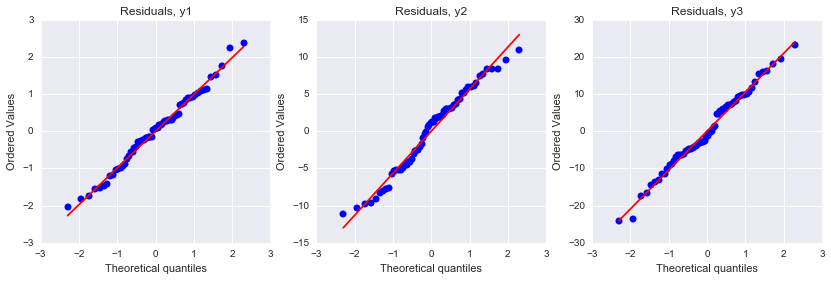

In [76]:
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *

# Quantify goodness of fit

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

r1 = y1 - est1.predict(x)
r2 = y2 - est2.predict(x)
r3 = y3 - est3.predict(x)

stats.probplot(r1, dist="norm", plot=ax1)
ax1.set_title('Residuals, y1')

stats.probplot(r2, dist="norm", plot=ax2)
ax2.set_title('Residuals, y2')

stats.probplot(r3, dist="norm", plot=ax3)
ax3.set_title('Residuals, y3')

pylab.show()

It's pretty evident that there are no significant trends being missed by the models. 

Another thing we can look at is the normalized error: what are the values? How are they distributed? A kernel density estimate (KDE) plot, which is a smoothed histogram, shows the probability distribution of the normalized residual errors. As expected, they're bunched pretty close to zero. There are some bumps far from zero, but as we saw from the quantile-quantile plots above, these residuals are distributed the same way normal, random variables are distributed; there's no systematic bias there.

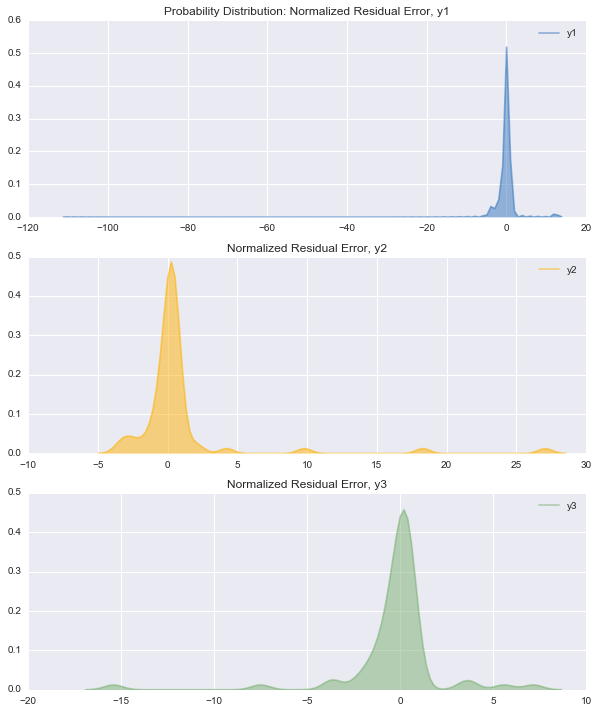

In [97]:
fig = figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
axes = [ax1,ax2,ax3]

colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

normed_resids = [r1/y1, r2/y2, r3/y3]

for (dataa, axx, colorr) in zip(normed_resids,axes,colors):
    sns.kdeplot(dataa, bw=0.5, ax=axx, color=colorr, shade=True, alpha=0.5);

ax1.set_title('Probability Distribution: Normalized Residual Error, y1')
ax2.set_title('Normalized Residual Error, y2')
ax3.set_title('Normalized Residual Error, y3')


Box and Draper next report aggregated experiment results, by computing the mean effect for the regressed variables. This is simple to do with Pandas, by grouping the data by each variable, and applying the mean function on all of the results. The code looks like this:

In [98]:
# Our original regression variables
xlabs = ['x2','x3','x4','x5','x6']
doe.groupby(xlabs)[ylabs].mean()

y1         y2         y3
x2 x3 x4 x5 x6                                
-1 -1 -1 -1 -1 -4.567357 -23.979564 -33.804709
             1 -3.141681 -16.725861 -24.739624
          1 -1 -2.738134 -11.268469 -44.287502
             1 -1.965749 -10.801018 -18.756849
       1 -1 -1 -1.044341  -5.582070 -16.373520
             1 -1.156612  -7.995561  -8.261020
          1 -1 -2.513352  -8.077014 -23.478010
             1  0.687739   3.601242   5.889389
    1 -1 -1 -1 -3.352291 -11.422101 -31.167194
             1 -1.823836  -9.806478   0.677809
          1 -1 -1.385703 -10.114762 -15.035090
             1  1.519005   6.213142  16.488915
       1 -1 -1 -1.222825 -11.360405 -16.709444
             1  1.248415   9.771690  12.751898
          1 -1  1.563490   9.597875  14.795152
             1  2.397995  14.383879  21.764756
 1 -1 -1 -1 -1 -4.147024  -5.396498 -44.622711
             1 -0.660031  -3.599554 -10.292235
          1 -1 -0.811912   1.672157  -3.088925
             1  0.738839  10.984220  13.323114
       1 -1 -1 -0.599424  -5.447673 -10.163477
             1  1.050384   8.493221   5.842473
          1 -1  1.154172   5.875858   4.737607
             1  2.553999  18.178415  27.336702
    1 -1 -1 -1 -2.463287  -6.939066 -21.255488
             1  0.571833   2.969601   0.066080
          1 -1  1.280118   7.284523  12.231235
             1  2.920946  16.047579  28.762989
       1 -1 -1  0.293640  -0.105504   4.083073
             1  3.126788  12.461804  40.494250
          1 -1  1.416656   5.050388  27.353658
             1  3.197488  27.284092  38.527867

In [99]:
# If we decided to go for a smaller variable set
xlabs = ['x2','x3','x4','x6']
doe.groupby(xlabs)[ylabs].mean()

y1         y2         y3
x2 x3 x4 x6                                
-1 -1 -1 -1 -3.652745 -17.624016 -39.046106
          1 -2.553715 -13.763439 -21.748237
       1 -1 -1.778846  -6.829542 -19.925765
          1 -0.234436  -2.197160  -1.185816
    1 -1 -1 -2.368997 -10.768432 -23.101142
          1 -0.152416  -1.796668   8.583362
       1 -1  0.170333  -0.881265  -0.957146
          1  1.823205  12.077785  17.258327
 1 -1 -1 -1 -2.479468  -1.862170 -23.855818
          1  0.039404   3.692333   1.515439
       1 -1  0.277374   0.214092  -2.712935
          1  1.802191  13.335818  16.589588
    1 -1 -1 -0.591585   0.172728  -4.512127
          1  1.746390   9.508590  14.414534
       1 -1  0.855148   2.472442  15.718366
          1  3.162138  19.872948  39.511059

This functionality can also be used to determine the variance in all of the experimental observations being aggregated:

In [100]:
doe.groupby(xlabs)[ylabs].var()

y1          y2          y3
x2 x3 x4 x6                                  
-1 -1 -1 -1  1.340299  108.831779   70.981983
          1  1.128468   18.964111  286.357606
       1 -1  0.924410   39.938778   34.070862
          1  1.425721   55.444438   71.246563
    1 -1 -1  2.223318    9.743790   98.088931
          1  5.563914  112.558021  255.497746
       1 -1  3.350490  162.076559  331.981871
          1  2.118444    8.073249   57.808280
 1 -1 -1 -1  4.392013   19.528154  582.934886
          1  0.740551   74.465961  348.405435
       1 -1  1.934560   67.424843  130.927411
          1  0.934969   65.833253  170.501629
    1 -1 -1  4.680672   73.681826  511.191745
          1  2.030972   75.027229  304.297140
       1 -1  0.484634   10.119007  184.284116
          1  0.539642  102.443385   33.904618

Or even the number of experimental observations being aggregated!

In [101]:
doe.groupby(xlabs)[ylabs].count()

y1  y2  y3
x2 x3 x4 x6            
-1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
 1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4

We can convert these dataframes of averages, variances, and counts into data for plotting. For example, if we want to make a histogram of every value in the groupby dataframe, we can use the ```.values``` method, so that this:

    doe.gorupby(xlabs)[ylabs].mean()

becomes this:


    doe.groupby(xlabs)[ylabs].mean().values


This $M \times N$ array can then be flattened into a vector using the ```ravel()``` method from numpy:

    np.ravel( doe.groupby(xlabs)[ylabs].mean().values )

The resulting data can be used to generate histograms, as shown below:

Grouping responses by interaction x2-x3-x4-x6


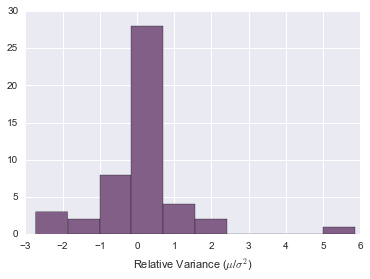

In [102]:
# Histogram of means of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = np.ravel(doe.groupby(xlabs)[ylabs].mean().values) / np.ravel(doe.groupby(xlabs)[ylabs].var().values)
plt.hist(dat, 10, normed=False, color=colors[3]);
plt.xlabel(r'Relative Variance ($\mu$/$\sigma^2$)')

Grouping responses by interaction x2-x3-x4-x6


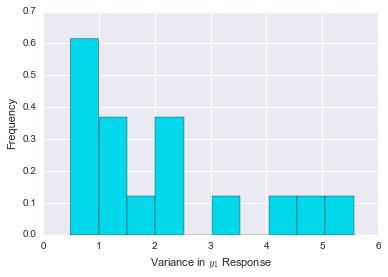

In [103]:
# Histogram of variances of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = np.ravel(doe.groupby(xlabs)['y1'].var().values)
plt.hist(dat, normed=True, color=colors[4]);
plt.xlabel(r'Variance in $y_{1}$ Response');
plt.ylabel(r'Frequency');